<a href="https://colab.research.google.com/github/AbhijyotAhire/GH1019994/blob/main/Supercharging_Sustainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Supercharging Sustainability: Harnessing Superconductors for Renewable Energy Innovation***


# **Part 1: Introduction**
The looming danger of intensified climate change, driven by the relentless emission of greenhouse gases from fossil fuel-based electricity generation, underscores the urgent need to transition towards sustainable energy sources swiftly.  The potential discovery of a room-temperature superconductor, LK-99, by South Korean researchers provides the opportunity for Superconducting Magnetic Energy Storage [SMES] which was invented in 1970. This technology is meant to effectively store energy through induction where electrons flow continuously within a superconducting coil wrapped around a core usually made from a niobium-titanium alloy embedded in a copper matrix. The primary benefits of SMES over other methods include nearly instantaneous power availability with a minimal time delay during charge and discharge, low power loss due to negligible electrical resistance, and enhanced reliability as its stationary components contribute to system stability. However, SMES systems can face increased complexity and operational cost due to their dependence on cryogenic cooling to maintain the superconducting state of the superconducting coil. The chance of LK-99‘s use in such a system remains low due to current research indicating a limited critical current of 250 mA (the maximum current where R=0) and a constrained maximum magnetic field threshold for maintaining superconductivity.

The primary objective of this notebook is to identify the plausibility of creating a solar battery that, when combined with a solar panel installation or any other renewable energy source, can sustain the energy consumption of an ideal American city. In order to do this, the data analysis algorithms will be employed for prediction and optimization


# Part 1.1 Aurora City: Pioneering Sustainability in a Vibrant Metropolis

Let's begin by imagining we are in Aurora City with a population of 1,024,144 people, and is a bustling metropolis known for its vibrant cultural scene, modern architecture, and diverse population. The city boasts a mix of historic neighborhoods and futuristic skyscrapers, offering a unique blend of old-world charm and contemporary innovation. With a strong emphasis on sustainability, Aurora City is home to lush parks, efficient public transportation, and a commitment to renewable energy sources. Its world-class universities, thriving tech industry, and rich culinary scene make it a hub of creativity and opportunity. In line with that commitment to sustainability, the city's government has pledges to move towards 100% solar electricity generation within the next 10 years.

In [6]:
!pip install prophet
!pip install cplex
!pip install stable_baselines3
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 76.3 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet
from scipy.optimize import minimize
import pulp
import matplotlib.pyplot as plt
import statistics
import sys
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import gymnasium as gym
from gymnasium import spaces

In [8]:
def get_readings_for_date(csv_file_path, target_date,time_column,energy_column):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    df[time_column] = pd.to_datetime(df[time_column])
    df['filter_date'] = df[time_column].dt.date
    filtered_df = df[df['filter_date'] == target_date]

    return filtered_df[[time_column,energy_column]]

In [9]:
def generate_random_date(delim):

    start_date = datetime.strptime('2015-9-1', '%Y-%m-%d')
    end_date = datetime.strptime('2018-8-2', '%Y-%m-%d')

    days_difference = (end_date - start_date).days
    random_days = random.randint(0, days_difference)

    random_date = (start_date + timedelta(days=random_days)).date()
    return f"{random_date.year}{delim}{random_date.month}{delim}{random_date.day}"
target_date = pd.to_datetime(generate_random_date("/"))
month = target_date.month
target_date

Timestamp('2016-11-17 00:00:00')

# **Part 2: Data Cleaning & Analysis**

# Part 2.1: Energizing Change: The Quest for Sustainable Power in Aurora City

To pave the way for a sustainable energy transformation, the city government assembles a team of experts, Solar Nexus Taskforce (SNT), tasked with crafting a viable strategy. Their objective was to orchestrate the reduction of the city's conventional power plants while simultaneously bolstering the deployment of solar panels and SMES solar batteries.

With determination, SNT promptly swings into action. The first step on their journey is to gather 2-3 years worth of energy consumption data from the city's power grid and energy production data from an existing solar field that will be undergoing a substantial expansion in the coming months.

In [13]:
csv_file_path = '/content/drive/MyDrive/Solar_Energy_Production.csv' # Solar energy production data sourced from solar installations in Calgary, Alberta
def get_production(date):
    production_readings_for_date = get_readings_for_date(csv_file_path, date.date(),'date','kWh').groupby('date')['kWh'].sum().reset_index()
    production_readings_for_date["kWh"] = production_readings_for_date["kWh"]*1000 # To account for a major scale-up in functionality
    return production_readings_for_date
production_readings_for_date = get_production(target_date)

In [15]:
consumption_csv_file_path = '/content/drive/MyDrive/AEP_hourly.csv'
# Electrical energy comsumption data from American Electric Power Company, Inc (AEP) which is among the nation's largest generators of electricity, owning nearly 38,000 megawatts of generating capacity in the U.S and serving nearly 5 million customers.
def get_consumption(date):
    consumption_readings_for_date = get_readings_for_date(consumption_csv_file_path, date.date(),'Datetime','AEP_MW').sort_values(by='Datetime')
    consumption_readings_for_date["AEP_MW"]=consumption_readings_for_date["AEP_MW"]*200
    # converts MW to kW and also scales down the data by a factor of 5 to make more representative of the demands of a city the size of  Auroa City
    # Set the 'datetime' column as the index
    consumption_readings_for_date.set_index('Datetime', inplace=True)
    return consumption_readings_for_date
consumption_readings_for_date = get_consumption(target_date)

In [16]:
production_readings_for_date.set_index("date", inplace=True)

# Adding in zeroes for the times not included with the assumption that those were times when the sun was not up
new_row = {"kWh":0}
for date in consumption_readings_for_date.index:
    if date not in production_readings_for_date.index:
        production_readings_for_date.loc[date] = new_row

production_readings_for_date = production_readings_for_date.sort_values(by='date')
production_readings_for_date

,kWh
date,
2016-11-17 00:00:00,0.0
2016-11-17 01:00:00,0.0
2016-11-17 02:00:00,0.0
2016-11-17 03:00:00,0.0
2016-11-17 04:00:00,0.0
2016-11-17 05:00:00,0.0
2016-11-17 06:00:00,0.0
2016-11-17 07:00:00,0.0
2016-11-17 08:00:00,246.0


In [17]:
energy_demand = ((consumption_readings_for_date['AEP_MW']-production_readings_for_date["kWh"]).mean())/1e6
total = (consumption_readings_for_date['AEP_MW'].mean())/1e6
f"Energy Demand Unfilled by Solar Installation on {target_date.date()}: {round(energy_demand,2)} GWh ({round(energy_demand/total,3)*100}% of demand)"

'Energy Demand Unfilled by Solar Installation on 2016-11-17: 2.79 GWh (100.0% of demand)'

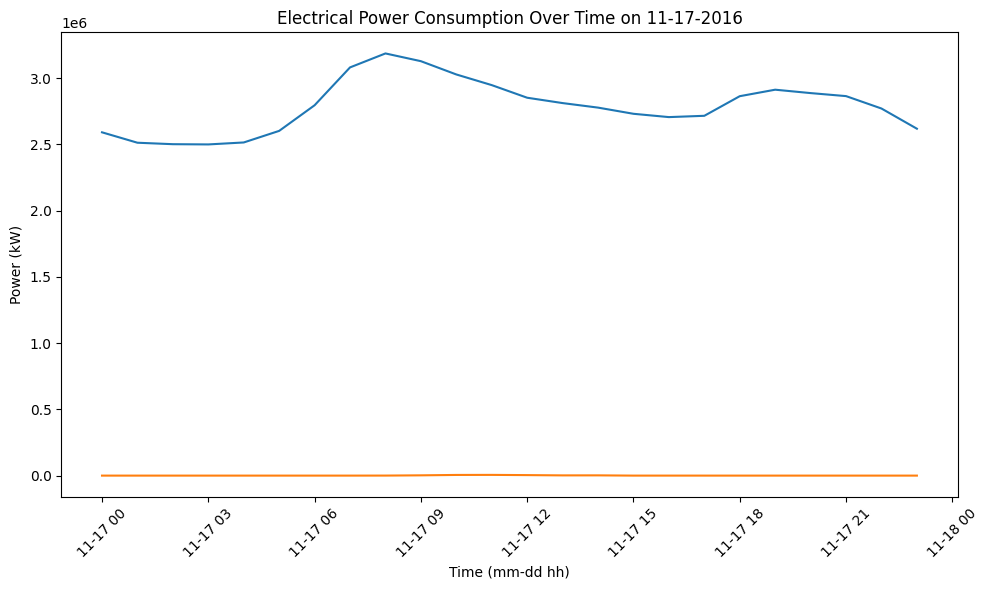

In [18]:
import matplotlib.pyplot as plt
# Plot datetime against energy consumption
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(consumption_readings_for_date.index, consumption_readings_for_date['AEP_MW'], production_readings_for_date.index, production_readings_for_date["kWh"])
plt.xlabel('Time (mm-dd hh)')
plt.ylabel('Power (kW)')
plt.title(f'Electrical Power Consumption Over Time on {datetime.strftime (target_date,"%m-%d-%Y")}')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

# Part 2.2: Unveiling Challenges: The City's Energy Quest Confronts Shadows
Amid caffeine-fueled calculations and simulations, a stark truth emerges from the data scientists' endeavors. A formidable challenge looms over the team. Within the conference room, a somber air settles as the lead data scientist projects slide after slide of graphs and statistics that each echoes a disheartening tale, such as those above. Despite the expansion of solar installation, the city's energy demands seem poised to surpass the solar yield. This disconcerting disparity casts a shadow over the team's ambitions.

With sleeves rolled up, the team ventures deep into the night, engrossed in brainstorming sessions. Yet, they soon end up going in circles. Recognizing the need for clarity, the director makes a call to dismiss the team so they can rest and return with renewed creativity. With crushed and weary spirits, they go home uncertain about the fate of a project that had once shown so much promise.


# **Part 3: Energy Forecasting & Optimization**

# Part 3.1: Renewed Resolve: Crafting a Dynamic Energy Strategy for Aurora City's Future

With the dawn of a new day comes hours of deliberation, leading to a consensus that they will stay the course, but with a more powerful battery to bridge the gap and the traditional power plants will still be able to pick up any remaining slack. Overcoming that challenge renews the team's faith in the project. They are ready to move to the next stage of the process which is working out how the solar installation and battery will handle the gradual buildup in electrical power demand that will result as the city phases out electricity from traditional power plants. The team begins working on a machine learning model to take into account the season, time of day in hours, and battery's charge level to create a dynamic strategy to handle the load of the city's electricity demands.

## Part 3.2: Entangled Choices: Navigating Neural Network Dilemmas in Energy Prediction

Regrettably, the team encounters another impasse, this time stemming from a difference in opinion about which tool to use. On one side are the data scientists, who were in favor of employing a technology known as Long Short-Term Memory (LSTM) neural networks. They believe these networks held the key to comprehending the complex puzzle of electricity distribution patterns.

The data scientists argue that LSTMs are like seasoned detectives of time. They can piece together patterns across various time frames – whether it is the daily rhythm, changing seasons, or even the subtle dance between different time intervals. This skill makes LSTMs an ideal choice to predict electricity distribution, as it depends on a delicate balance of many variables, like the time of day, the battery's energy, and the electricity demand.

On the opposing side, the software developers advocate for Gated Recurrent Unit (GRU) neural networks. They see these networks as intelligent and efficient navigators of data. "GRUs are like streamlined drivers that ensured a smooth ride even through intricate datasets, helping to keep the project on track and within budget" explained an impassioned junior developer.

As spirited debates ensue, the team's director steps in, recognizing merit in both arguments. After careful reflection, the director leans towards the LSTM approach, appreciating its prowess in capturing time-driven intricacies. Believing that LSTMs could equip the team with superior insights for accurate electricity distribution forecasts, the director's decision was made. The software developers, albeit begrudgingly, collaborate with the data science team to construct and train the LSTM neural network.

Yet, just as discussions settled, a new voice emerged. Inspired by a recent tech seminar, one of the team's interns proposes harnessing the predictive power of Prophet from Facebook. The intern explains that Prophet is a forecasting tool that excels at predicting time-series data with multiple patterns and trends. Its ability to automatically detect seasonality and handle missing data makes it well-suited for predicting electricity distribution patterns. The director, open to innovation, reweighs the options and ultimately embraces the intern's suggestion. With fresh hope, the team embarks on a new phase – navigating the uncharted waters of energy forecasting using a novel tool.


In [19]:
df = pd.read_csv(consumption_csv_file_path)
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [20]:
consumption_df = pd.DataFrame()
consumption_df["ds"]=df["Datetime"]
consumption_df["y"]=df["AEP_MW"]*200
consumption_df["y"].max()

5139000.0

In [21]:
p_df = pd.read_csv(csv_file_path)
production_df = pd.DataFrame()
production_df["ds"] = p_df["date"]
production_df["y"]= p_df["kWh"]*1000
production_df

,ds,y
0,2017/09/11 08:00:00 AM,1130.0
1,2017/09/11 09:00:00 AM,2340.0
2,2017/09/11 10:00:00 AM,3656.0
3,2017/09/11 11:00:00 AM,4577.0
4,2017/09/11 12:00:00 PM,6506.0
...,...,...
258418,2023/03/12 03:00:00 PM,201285.0
258419,2023/03/12 04:00:00 PM,162582.0
258420,2023/03/12 05:00:00 PM,107060.0
258421,2023/03/12 06:00:00 PM,43074.0


In [22]:
c_model = Prophet()
c_model.fit(consumption_df)
future = c_model.make_future_dataframe(periods=131424, freq="H", include_history=False)
future

DEBUG:cmdstanpy:input tempfile: /tmp/tmparyol1fe/9i2acnni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmparyol1fe/3rig91i7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61744', 'data', 'file=/tmp/tmparyol1fe/9i2acnni.json', 'init=/tmp/tmparyol1fe/3rig91i7.json', 'output', 'file=/tmp/tmparyol1fe/prophet_model99rkrqaz/prophet_model-20241103231846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:18:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:21:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds
0,2018-08-03 01:00:00
1,2018-08-03 02:00:00
2,2018-08-03 03:00:00
3,2018-08-03 04:00:00
4,2018-08-03 05:00:00
...,...
131419,2033-07-30 20:00:00
131420,2033-07-30 21:00:00
131421,2033-07-30 22:00:00
131422,2033-07-30 23:00:00


In [23]:
p_model = Prophet()
p_model.fit(production_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmparyol1fe/k6_67zh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmparyol1fe/tm07u9k1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32585', 'data', 'file=/tmp/tmparyol1fe/k6_67zh8.json', 'init=/tmp/tmparyol1fe/tm07u9k1.json', 'output', 'file=/tmp/tmparyol1fe/prophet_model8m33kni1/prophet_model-20241103232134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:21:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:24:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


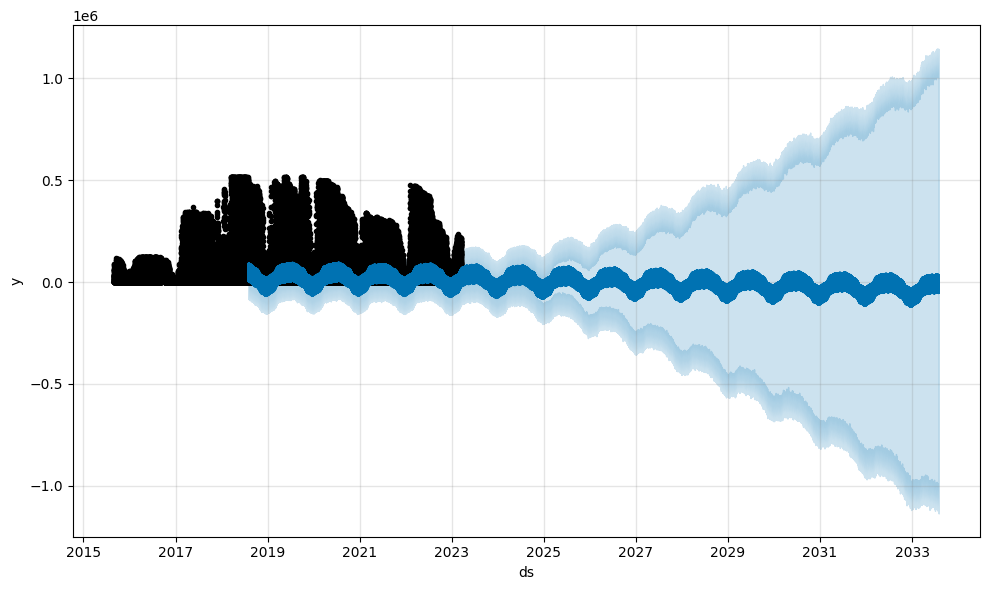

In [24]:
production_forecast=p_model.predict(future)
fig2 = p_model.plot(production_forecast)

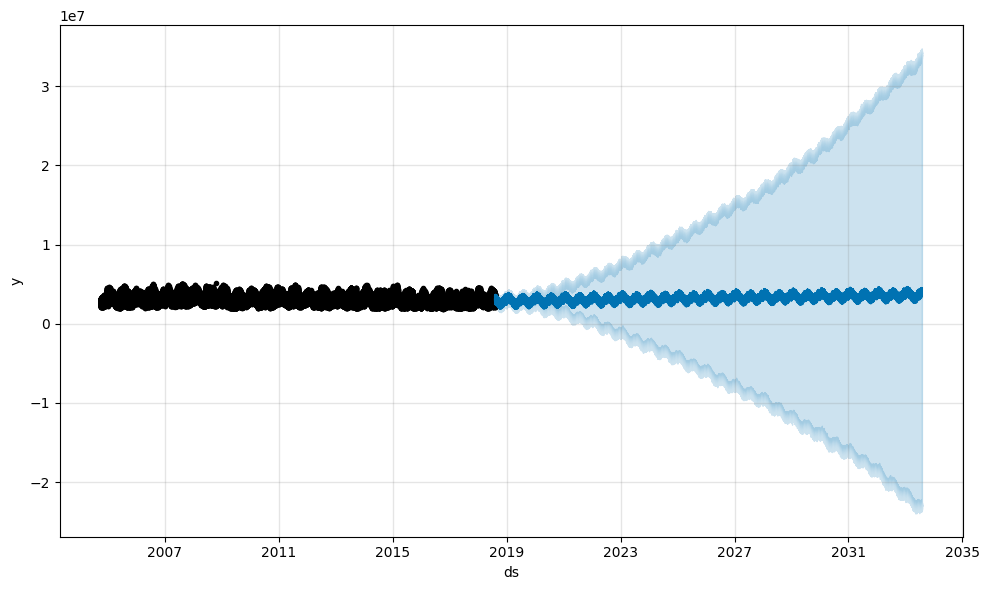

In [25]:
forecast = c_model.predict(future)
fig1 = c_model.plot(forecast)

# Part 3.3: Optimizing Power Flow: Bridging Solar, SMES, and the City's Grid

The team has finished the predictions for solar installation energy production and the city's energy demand for the next decade. Now they are one step closer to implementation. However, first, they need to use their predictions to determine the optimum battery energy capacity and power flow among the solar installation, the SMES, and the city's power grid.

## Mathematical Modeling Equation Setup

### Superconducting Magnetic Energy System (SMES)
The team started their optimization by looking at Equivalent Full Cycle (EFC). EFC is the overall energy delivered which represents the complete charging and discharging process of the energy storage system, and it can be estimated by:
> $EFC(t) = \dfrac{1}{2}\times\dfrac{\bigg| \eta_{ch}P_{ch}(t)-\dfrac{P_{dis}(t)}{\eta_{dis}}\bigg |\Delta t}{Cap_{batt}}$

In this formula, $\eta_{ch}$ & $\eta_{dis}$ refer to the charging and discharging efficiency of the energy storage system. Since the system here uses superconductors, the effiency is 100% so the team assumes $\eta_{ch} = \eta_{dis} = 1$. They plug this into the equation and simiplify it to get the formula for EFC from rewritten as:
> $EFC(t) = \dfrac{1}{2}\times\dfrac{\bigg|P_{ch}(t)-P_{dis}(t)\bigg |\Delta t}{Cap_{batt}}$
>, where:
> * $P_{ch}(t)$: charging power in kW,
>* $P_{dis}(t)$: discharging power in kW,
>* ${Cap_{batt}}$: battery capacity in kWh,
>* $\Delta t$: time step which in this scenario is 1 hour

From the EFC, the team can find the state of charge, SOC, of an energy storage system. State of charge refers to the amount of energy stored in a battery or energy storage system as a percentage of its total capacity. The relationship between SOC and EFC is given by the following recursive function:
>$SOC(t)=SOC(t-1)+EFC(t)$

### Constraints

#### Electrical Balance Constraints

**$p^{load}_y(t) =p^{pv-l}_y(t)+p^{b-l}_y(t)+p^{g-l}_y(t)$**, where:
>* $p^{load}_y(t)$: total electricity load
>* $p^{pv-l}_y(t)$: electricity load satisfied by solar installation
>* $p^{b-l}_y(t)$: electricity load satisfied by SMES
>* $p^{g-l}_y(t)$: electricity load satisfied by traditional power plants

**$p^{PV}_y(t) =p^{pv-l}_y(t)+p^{pv-b}_y(t)$**, where:
>* $p^{PV}_y(t)$: total electric power output from solar installation
>* $p^{pv-l}_y(t)$: electric power supplied by solar installation to satisfy by solar electricity load
>* $p^{pv-b}_y(t)$: electric power supplied by solar installation to SMES

#### SMES Operation Constraints

$0 ≤ Cap_{batt} ≤ Cap^{max}_{batt}$

$P^{pv-b}_y (t) ≤ \dfrac{z_{ch,y}(t)\times Cap_{batt}}{3}$

$P^{b-l}_y(t)≤\dfrac{z_{dis,y}(t)\times Cap_{batt}}{3}$

$z_{ch,y}(t)+z_{dis,y}(t) ≤ 1$

##

In [26]:
def LCC(batt_cap):
    return (batt_cap*unit_cap_price)+((coeff_op_main*(batt_cap*unit_cap_price))*calendric_life)

In [27]:
optimal_capacity = 0
battery_capacity = optimal_capacity
min_soc = 0.1
max_soc = 0.98
calendric_life = 10 # years
cycle_life = 100000 #cycles
coeff_op_main = 0.03
unit_cap_price=0.169 # $/kWh
cost_batt = battery_capacity*unit_cap_price
cost_op_m = (coeff_op_main*cost_batt)*8760*calendric_life

In [28]:
a,b = int(4e6), int(6e6) #Initial Interval [a,b]
r = (1-math.sqrt(5))/2 # Goldent Ratio
tolerance = 1e-8 # Tolerance for convergence

while abs((b-a)/b)>tolerance:
    a1 = b-r*(b-a)
    a2 = a+r*(b-a)
    if LCC(a1)>LCC(a2):
        a=a1
    else:
        b=a2
optimal_capacity = (a+b)/2
f"Optimal Battery Capacity: {optimal_capacity/1e6} GWh"

'Optimal Battery Capacity: 9.236067850615498 GWh'

In [29]:
forecast_df=pd.DataFrame()
forecast_df["Datetime"] = future["ds"][43775:]
forecast_df["P_load"] = forecast["yhat"][43775:]
forecast_df["P_PV"] = production_forecast["yhat_upper"][43775:]
forecast_df=forecast_df.reset_index()
forecast_df

,index,Datetime,P_load,P_PV
0,43775,2023-08-01 00:00:00,3.531889e+06,1.105987e+05
1,43776,2023-08-01 01:00:00,3.381498e+06,1.209413e+05
2,43777,2023-08-01 02:00:00,3.267558e+06,1.143785e+05
3,43778,2023-08-01 03:00:00,3.202068e+06,9.927131e+04
4,43779,2023-08-01 04:00:00,3.194660e+06,8.596262e+04
...,...,...,...,...
87644,131419,2033-07-30 20:00:00,4.120116e+06,1.040487e+06
87645,131420,2033-07-30 21:00:00,4.081582e+06,1.037570e+06
87646,131421,2033-07-30 22:00:00,3.976807e+06,1.037338e+06
87647,131422,2033-07-30 23:00:00,3.821163e+06,1.054384e+06


# **Part 4: Empowering the Future: Implementing the Vision**

After several long nights of meticulous planning, the team transitioned from predictions to action, orchestrating a seamless integration of the solar installation, the SMES, and the city's power grid. The skyline transformed as advanced solar arrays and the sleek SMES installation emerged, showcasing Aurora City's commitment to a sustainable future.

In [30]:
def calc_power_from_power_plant(params,ind):
    charging_power, discharging_power = params
    power = forecast_df["P_load"][ind]-forecast_df["P_PV"][ind]+charging_power-discharging_power
    if power>0:
        return power[0]
    else:
        return 0

In [31]:
class PowerOptimizationEnv(gym.Env):
    def __init__(self):
        super(PowerOptimizationEnv, self).__init__()

        # Define simulation parameters
        #self.total_time_steps = len(forecast_df["Datetime"])
        self.battery_capacity = optimal_capacity
        self.current_time = 0
        self.power_plant_power = 0

        self.optimal_power_charge_list = []
        self. optimal_power_discharge_list = []
        self.minimal_power_from_power_plant_list = [sys.maxsize]
        self.battery_capacity_list = []

        # Define observation space (state)
        self.observation_space = spaces.Box(low=0, high=20000000, shape=(3,), dtype=np.float64)

        # Define action space (charge and discharge)
        self.action_space = spaces.Box(low=self.battery_capacity/-3, high=self.battery_capacity/3, shape=(1,), dtype=np.float64)  # Continuous action

        # Other environment-specific parameters
    def calc_reward(self):
        power_reduction =  self.minimal_power_from_power_plant_list[-2]- self.minimal_power_from_power_plant_list[-1]
        if self.battery_capacity<0:
            return sys.maxsize*-1
        else:
            return float(power_reduction+self.battery_capacity)

    def step(self, action):
        # Simulate environment dynamics and calculate reward
        self.battery_capacity+=(action[0]*1e6)
        if action >= 0:
            self.power_plant_power = calc_power_from_power_plant([action*1e6, 0],self.current_time)
            self.optimal_power_charge_list.append(action[0]*1e6)
            self.optimal_power_discharge_list.append(0)
            self.minimal_power_from_power_plant_list.append(self.power_plant_power)
            self.battery_capacity_list.append(self.battery_capacity)

        else:
            self.power_plant_power = calc_power_from_power_plant([0, action], self.current_time)
            self.optimal_power_charge_list.append(0)
            self.optimal_power_discharge_list.append(action[0]*1e6)
            self.minimal_power_from_power_plant_list.append(self.power_plant_power)
            self.battery_capacity_list.append(self.battery_capacity)

         # Update self.current_time and other environment variables
        self.current_time+=1
        # Return next_observation, reward, done, info
        next_observation = np.array([self.battery_capacity, self.current_time, self.power_plant_power], dtype=np.float64)
        reward = self.calc_reward()
        if self.current_time%24 == 0 :
            done = True
        else:
            done = False
        info = {'step': self.current_time}

        if self.current_time>=87647:
            truncated = True
        else:
            truncated = False

        return next_observation, reward,done, truncated, info

    def reset(self,seed=None):
        info = {'step': self.current_time}
        self.current_time = 0

        return np.array([self.battery_capacity, self.current_time, self.power_plant_power], dtype=np.float64).astype(float),info


In [32]:
env = PowerOptimizationEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=87600)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | 1.09e+17 |
| time/              |          |
|    fps             | 1004     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 24            |
|    ep_rew_mean          | -7.56e+18     |
| time/                   |               |
|    fps                  | 703           |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 4.2491592e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2       

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/utils.py:65: RuntimeWarning: invalid value encountered in scalar divide
  return np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y


--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 24             |
|    ep_rew_mean          | -4.14e+19      |
| time/                   |                |
|    fps                  | 712            |
|    iterations           | 3              |
|    time_elapsed         | 8              |
|    total_timesteps      | 6144           |
| train/                  |                |
|    approx_kl            | -3.4924597e-09 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -1.42          |
|    explained_variance   | nan            |
|    learning_rate        | 0.0003         |
|    loss                 | inf            |
|    n_updates            | 20             |
|    policy_gradient_loss | -5.94e-10      |
|    std                  | 1              |
|    value_loss           | inf            |
--------------------------------------------
----------

In [33]:
test_env = PowerOptimizationEnv()
obs = test_env.reset()[0].astype(float)
for i in range(87649):
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = test_env.step(action)

In [34]:
results_df = pd.DataFrame()
results_df["Charging Power"] = test_env.optimal_power_charge_list
results_df["Discharging Power"] = test_env. optimal_power_discharge_list
results_df["Power Plant Power Output"] = test_env.minimal_power_from_power_plant_list[1:]
results_df["Battery Capacity"] = test_env.battery_capacity_list

In [35]:
results_df

,Charging Power,Discharging Power,Power Plant Power Output,Battery Capacity
0,0.000000,-7.450782e+05,3.421291e+06,8.490990e+06
1,0.000000,-3.119832e+05,3.260557e+06,8.179006e+06
2,0.000000,-1.295595e+06,3.153181e+06,6.883411e+06
3,0.000000,-5.152942e+05,3.102798e+06,6.368117e+06
4,0.000000,-1.206034e+05,3.108698e+06,6.247514e+06
...,...,...,...,...
87644,130394.876003,0.000000e+00,3.210024e+06,5.647234e+07
87645,495008.438826,0.000000e+00,3.539021e+06,5.696735e+07
87646,0.000000,-2.949541e+06,2.939472e+06,5.401781e+07
87647,796069.562435,0.000000e+00,3.562848e+06,5.481388e+07


In [36]:
percent_change=(results_df["Power Plant Power Output"][87648]-results_df["Power Plant Power Output"][0])/results_df["Power Plant Power Output"][0]
if percent_change<0:
    print(f"Auroa City has experienced a {percent_change*-100:.2f}% decrease in power plant power over 10 years")
elif percent_change>0:
    print(f"Auroa City has experienced a {percent_change*100:.2f}% increase in power plant power over over 10 years")
else:
    print("No change")

Auroa City has experienced a 0.57% increase in power plant power over over 10 years


# Part 4 Cont.

As the system went live, a triumphant moment arrived – the city had significantly decreased its dependence on nonrenewable energy, and the SMES battery stood ready to bridge the gap after the sun sets. This success radiated beyond energy, inspiring schools to weave the tale into curricula and motivating other cities to pursue their sustainable dreams. Amidst challenges, Aurora City's story demonstrated that a cleaner, brighter tomorrow is achievable through collaboration, innovation, and resilience, marking a new chapter for the city and the end of our story.

# References

1. [arXiv:2307.12008v1](https://arxiv.org/abs/2307.12008) **[cond-mat.supr-con]**
2. [American Electric Power Company, Inc. (AEP) Company Website](https://www.aep.com/about/businesses/opcos)
3. [Optimal battery capacity of grid-connected PV-battery systems considering battery degradation](https://doi.org/10.1016/j.renene.2021.09.036.)